In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
from torch import load
from torch.nn import functional as F
from torch import autograd

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from NTKs import calculate_NTK
from einops import rearrange

import time

import sys
from pathlib import Path

In [2]:
cuda = True

epochs = 10
batch_size = 64
learning_rate = 5e-2
n_workers = 1

#COMPUTE HESSIAN must be true for either save full hessian or saveing exact EST
SAVE_WEIGHTS = False
SAVE_HESSIAN = False
SAVE_NTK = False
TEST=False

HOW_MANY_MNIST = 60_000 #instead of using the full mnist training data, using randomly sampled subset
optimizer_keyword = 'SGD' #or 'GD'

#filename = sys.argv[1]
filename = 'MLP_efficeint_SGD_spectralnorm'

IMAGE_DIR = '../IMAGES/{}/'.format(filename)
MODEL_DIR = '../MODELS/'+filename+'/'
DATA_DIR = '../DATA/'
HESS_DIR = '../HESS/FULL/{}/'.format(filename)
NTK_DIR = '../NTK/EXACT/{}/'.format(filename)
CONJUGATE_DIR = '../CONJUGATE_KERNEL/{}/'.format(filename)

device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [3]:
data = load(DATA_DIR+'training.pt')
mnist_digits = data[0]
mnist_labels = data[1]

np_tensor = mnist_digits.numpy()
label_np = mnist_labels.numpy()
#np.random.shuffle(np_tensor) #multidimensional arrays are shuffled along their first axis only


np.random.seed(0)

if HOW_MANY_MNIST:
    indices = np.arange(0,60_000)
    np.random.shuffle(indices)
    
    np_tensor = np_tensor[indices,][0:HOW_MANY_MNIST,]
    label_np = label_np[indices,][0:HOW_MANY_MNIST,]

expanded = np.expand_dims(np_tensor, -1).astype("float32") / 255

expanded = rearrange(expanded,'b h w c -> b c h w')

# wrap tensors into a dataset
train_ds = TensorDataset(torch.from_numpy(expanded), torch.from_numpy(label_np))
if optimizer_keyword == 'SGD':
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=n_workers)
if optimizer_keyword == 'GD':
    #I beleive this is the only difference
    train_dl = DataLoader(train_ds, batch_size=HOW_MANY_MNIST or 60_000, shuffle=True, num_workers=n_workers)
    
NTK_dl = DataLoader(train_ds, batch_size=HOW_MANY_MNIST or 60_000, shuffle=False, num_workers=n_workers)

In [4]:
data = load(DATA_DIR+'test.pt')
mnist_digits_test = data[0]
mnist_labels_test = data[1]

np_tensor = mnist_digits_test.numpy()
expanded_test = np.expand_dims(np_tensor, -1).astype("float32") / 255
expanded_test = rearrange(expanded_test,'b h w c -> b c h w')
# wrap tensors into a dataset
test_ds = TensorDataset(torch.from_numpy(expanded_test), mnist_labels_test)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=n_workers)

# Architecture

In [102]:
def relu(X,normalize=True):
    X = F.relu(X)
    if normalize:
        return np.sqrt(2*np.pi/(np.pi-1))*(X-1/np.sqrt(2*np.pi))
    else:
        return X

class MNIST_LeNet5(torch.nn.Module):
    '''
    Instead, lets use the principles of LeNet5 and combine with modern techniques
    
    Basically, I'm going to use padding and a kernel size of 3 instead.
    '''
    def __init__(self,channels_in=1):
        super(MNIST_LeNet5, self).__init__()
        
        self.c1 = torch.nn.Conv2d(channels_in,6,kernel_size=3,padding=1) #28,28 -> 28x28
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2,stride=2) #14,14
        
        self.c2 = torch.nn.Conv2d(6,16,kernel_size=3,stride=1,padding=1) #14,14 -> 14x14
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2,stride=2) #14x14 -> 7x7
        
        self.l1 = torch.nn.Linear(16*7*7,120)
        self.l2 = torch.nn.Linear(120,84)
        self.l3 = torch.nn.Linear(84,10)
        
        
    def forward(self,x):
        x = torch.nn.functional.tanh(self.c1(x))
        x = torch.nn.functional.tanh(self.pool1(x))
        
        x = torch.nn.functional.tanh(self.c2(x))
        x = torch.nn.functional.tanh(self.pool2(x))
        
        x = x.reshape(-1,16*7*7)
        
        x = torch.nn.functional.tanh(self.l1(x))
        x = torch.nn.functional.tanh(self.l2(x))
        x = torch.nn.functional.log_softmax(self.l3(x),dim=1)
        
        return x

In [103]:
class Vanilla_CNN(torch.nn.Module):
    def __init__(self,channels_in=1):
        super(Vanilla_CNN, self).__init__()
        
        self.c1 = torch.nn.Conv2d(channels_in,128,kernel_size=5,padding=0,bias=False) #24x24
        
        self.l1 = torch.nn.Linear(128*24*24,1,bias=False)
        
    def forward(self,x):
        x = relu(self.c1(x)) * (1/np.sqrt(6* 5 * 5))
        print(x.shape)
        x = x.view(x.shape[0],-1)
        x = self.l1(x)
        return x

In [104]:
device='cpu'
model = Vanilla_CNN()
model.to(device)

Vanilla_CNN(
  (c1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (l1): Linear(in_features=73728, out_features=1, bias=False)
)

In [105]:
print('Num Params: ',sum(p.numel() for p in model.parameters() if p.requires_grad))

Num Params:  76928


In [106]:
#https://discuss.pytorch.org/t/how-to-fix-define-the-initialization-weights-seed/20156/3
def selfnormalizing_weights(m):
    if isinstance(m, nn.Linear):
        print(m.weight.shape)
        nn.init.normal_(m.weight.data,0,1/np.sqrt(m.weight.shape[0])) 
        if m.bias != None:
            nn.init.normal_(m.bias.data,0,1/np.sqrt(m.weight.shape[0]))
    if isinstance(m, nn.Conv2d):
        print(m.weight.shape)
        nn.init.normal_(m.weight.data,0,1/np.sqrt(m.weight.shape[0])) 
        if m.bias != None:
            nn.init.normal_(m.bias.data,0,1/np.sqrt(m.weight.shape[0]))
            
def NTK_weights(m):
    if isinstance(m, nn.Linear):
        print(m.weight.shape)
        nn.init.normal_(m.weight.data)#/m.weight.shape[0]
        if m.bias != None:
            nn.init.normal_(m.bias.data)#/m.weight.shape[0]
    if isinstance(m, nn.Conv2d):
        print(m.weight.shape)
        nn.init.normal_(m.weight.data)#/m.weight.shape[0]
        if m.bias != None:
            nn.init.normal_(m.bias.data)#/m.weight.shape[0]

model.apply(NTK_weights)

torch.Size([128, 1, 5, 5])
torch.Size([1, 73728])


Vanilla_CNN(
  (c1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (l1): Linear(in_features=73728, out_features=1, bias=False)
)

In [109]:
#has to be done on the CPU for reasons of we're doing something that pytorch thinks is werid
x_test_ntk = torch.from_numpy(np.random.normal(0,1.0,size=(100,1,28,28)).astype(np.float32))/28

NTK = calculate_NTK(model,x_test_ntk,device=device)

torch.Size([100, 128, 24, 24])


# Train

In [13]:
device='cuda'
model.to(device)

MNIST_LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (l1): Linear(in_features=784, out_features=120, bias=True)
  (l2): Linear(in_features=120, out_features=84, bias=True)
  (l3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('number of model params: ',pytorch_total_params)

number of model params:  106154


In [16]:
def train(epoch):
    model.train()
    train_loss_tracker = []
    epoch_begin=time.time()
    
    correct=0
    for batch_idx, (data, y) in enumerate(train_dl):
        data = data.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat = model(data)
        loss = torch.nn.functional.nll_loss(y_hat, y)  
        loss.backward() #this is probably re-calculating the gradients...
        optimizer.step()
        
        train_loss_tracker.append(loss.item())
       
    epoch_loss = np.mean(train_loss_tracker)
    
    return epoch_loss

def test(epoch):
    model.eval()
    test_loss_tracker = []
    with torch.no_grad():
        correct=0
        for batch_idx, (data, y) in enumerate(test_dl):
            data = data.to(device)
            y = y.to(device)
            y_hat = model(data)
            loss = torch.nn.functional.nll_loss(y_hat, y)
            
            pred = y_hat.data.max(1, keepdim=True)[1]
            correct += int(pred.eq(y.data.view_as(pred)).sum().to('cpu'))
            
            test_loss_tracker.append(loss.item())
            
            
        return np.mean(test_loss_tracker), 100.* correct/len(test_dl.dataset)

In [17]:
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

for epoch in range(1,epochs+1):
    T_start = time.time()
    
    epoch_loss = train(epoch)
    train_loss_history.append(epoch_loss)
    #Now our test metrics
    epoch_loss, acc = test(epoch)
    test_loss_history.append(epoch_loss)
    test_acc_history.append(acc)
    #Now pring some diagnostic to the user
    print('Epoch: {}, Time: {}, Train Loss: {}, Test Loss: {}, Test Acc: {}'.format(
    epoch,
    np.round(time.time() - T_start,2),
    np.round(train_loss_history[-1],5),
    np.round(test_loss_history[-1],5),
    np.round(test_acc_history[-1],5),
    ),flush=True)
    
    
#record_stuff_for_NTK('CK-final.pt')
#torch.save(model.state_dict(),MODEL_DIR+filename+'-final')
    
history_dict = {}
history_dict['train_loss'] = train_loss_history
history_dict['test_loss'] = test_loss_history
history_dict['train_acc'] = train_acc_history
history_dict['test_acc'] = test_acc_history
history_dict['batch_size'] = batch_size
history_dict['learning_rate'] = learning_rate

#np.save(MODEL_DIR + 'history.npy',history_dict)

Epoch: 1, Time: 14.25, Train Loss: 1.81824, Test Loss: 1.31504, Test Acc: 52.87
Epoch: 2, Time: 5.25, Train Loss: 1.08159, Test Loss: 0.82022, Test Acc: 74.71
Epoch: 3, Time: 5.1, Train Loss: 0.81457, Test Loss: 0.79719, Test Acc: 74.06
Epoch: 4, Time: 5.03, Train Loss: 0.69367, Test Loss: 0.67768, Test Acc: 78.96
Epoch: 5, Time: 5.12, Train Loss: 0.61293, Test Loss: 0.65094, Test Acc: 80.47
Epoch: 6, Time: 5.11, Train Loss: 0.56008, Test Loss: 0.57934, Test Acc: 82.96
Epoch: 7, Time: 5.07, Train Loss: 0.5181, Test Loss: 0.50211, Test Acc: 85.96
Epoch: 8, Time: 5.11, Train Loss: 0.48042, Test Loss: 0.44652, Test Acc: 87.21
Epoch: 9, Time: 5.12, Train Loss: 0.45316, Test Loss: 0.49924, Test Acc: 85.85
Epoch: 10, Time: 5.18, Train Loss: 0.42747, Test Loss: 0.39558, Test Acc: 88.91


In [18]:
device='cpu'
model.to(device)

x_test_ntk = torch.from_numpy(expanded_test[0:200,])
NTK_after = calculate_NTK(model,x_test_ntk)

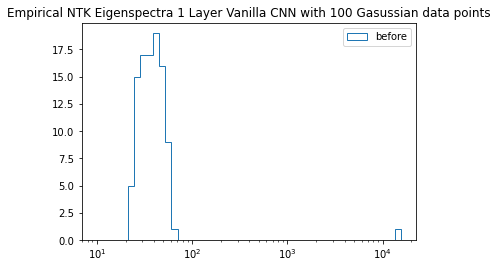

In [112]:
eigenvalues, eigenvectors = np.linalg.eigh(NTK)
plt.hist(eigenvalues.flatten(),np.logspace(1,np.log10(np.max(eigenvalues)),50,base=10),density=False,histtype='step',label='before')
#eigenvalues, eigenvectors = np.linalg.eigh(NTK_after)
#plt.hist(eigenvalues.flatten(),np.logspace(np.log10(np.min(eigenvalues)),np.log10(np.max(eigenvalues)),50,base=10),density=False,histtype='step',label='after')
plt.xscale('log')
plt.title('Empirical NTK Eigenspectra 1 Layer Vanilla CNN with 100 Gasussian data points')
plt.legend()
plt.show()

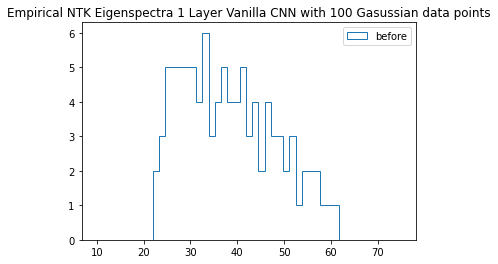

In [117]:
eigenvalues, eigenvectors = np.linalg.eigh(NTK)
plt.hist(eigenvalues.flatten(),np.linspace(10,75,50,),density=False,histtype='step',label='before')
#eigenvalues, eigenvectors = np.linalg.eigh(NTK_after)
#plt.hist(eigenvalues.flatten(),np.logspace(np.log10(np.min(eigenvalues)),np.log10(np.max(eigenvalues)),50,base=10),density=False,histtype='step',label='after')
plt.xscale('linear')
plt.title('Empirical NTK Eigenspectra 1 Layer Vanilla CNN with 100 Gasussian data points')
plt.legend()
plt.show()